# Step size effect in Metropolis Algorithm
As in [exercise 05](05_MetropolisAlgorithm.ipynb), consider the data `data_ex05.npy`. Assume $X$ is distributed according to a normal:
$$
    f_X(x|\mu, \sigma)=\frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{1}{2}\frac{(x-\mu)^2}{\sigma^2}}
$$
where 
- $f_{prior}(\mu) \sim \mathcal{N}(m, s^2)$, with $m=4$, $s=2$;
- $f_{prior}(\sigma) \sim I\mathcal{\Gamma}(\alpha, \beta)$ with $\alpha=2$, $\beta=1$. 

Estimate $\mu$, $\sigma$ as posterior averages (with errors given by posterior standard deviations) from the data, using Metropolis algorithm to sample. In other words, using Metropolis algorithm sample
$$
    f(\mu, \sigma | x) \propto f_X(x|\mu, \sigma)\cdot f_{prior}(\mu) \cdot f_{prior}(\sigma)
$$
The proposal step $T(\mu', \sigma'| \mu, \sigma)$ is normal with step size $\epsilon$:
$$
    \begin{cases}
        \mu' &\sim \mathcal{N}\left(\mu, \epsilon^2\right) \\
        \sigma' &\sim \mathcal{N}\left(\sigma, \epsilon^2\right)
    \end{cases}
$$ 

## Task
Try different step sizes, $\epsilon = [10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 0.5]$ and observe qualitatively the behavior of the chain and the convergence speed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import math 

from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

data = np.load('./data/data_ex05.npy')
print('There are %i data points' %len(data))

There are 10000 data points


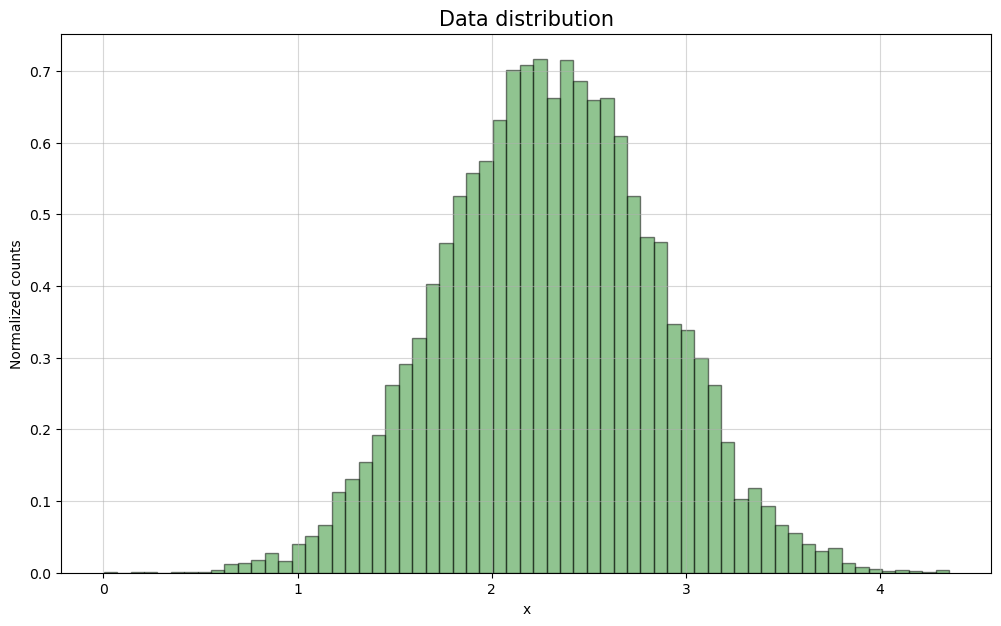

In [2]:
# plot data distribution 
fig, ax = plt.subplots(figsize=(12, 7))

hist_val_div = ax.hist(data, bins='fd', edgecolor='black', alpha=0.5, density=True, color='forestgreen')

ax.set_xlabel('x', fontsize=10)
ax.set_ylabel('Normalized counts', fontsize=10)
ax.grid(alpha=0.5)
ax.set_title('Data distribution', fontsize=15)

plt.show()

In [3]:
def log_likelihood(x, mu, sigma):
    return np.log(1/np.sqrt(2*np.pi*sigma))-0.5*(x-mu)**2/(sigma**2)

def log_prior_mu(mu, m, s):
    return np.log(1/np.sqrt(2*np.pi*s))-0.5*(mu-m)**2/(s**2)

def log_prior_sigma(sigma, alpha, beta):
    def inverse_gamma(x, alpha_, beta_):
        return beta_**alpha_/math.gamma(alpha_)*(1/x)**(alpha+1)*np.exp(-beta_/x)
        
    return np.log(inverse_gamma(sigma, alpha, beta))

def log_posterior(mu, sigma, x, m=4, s=2, alpha=2, beta=1):
    return np.sum(log_likelihood(x, mu, sigma)) + log_prior_mu(mu, m, s) + log_prior_sigma(sigma, alpha, beta)

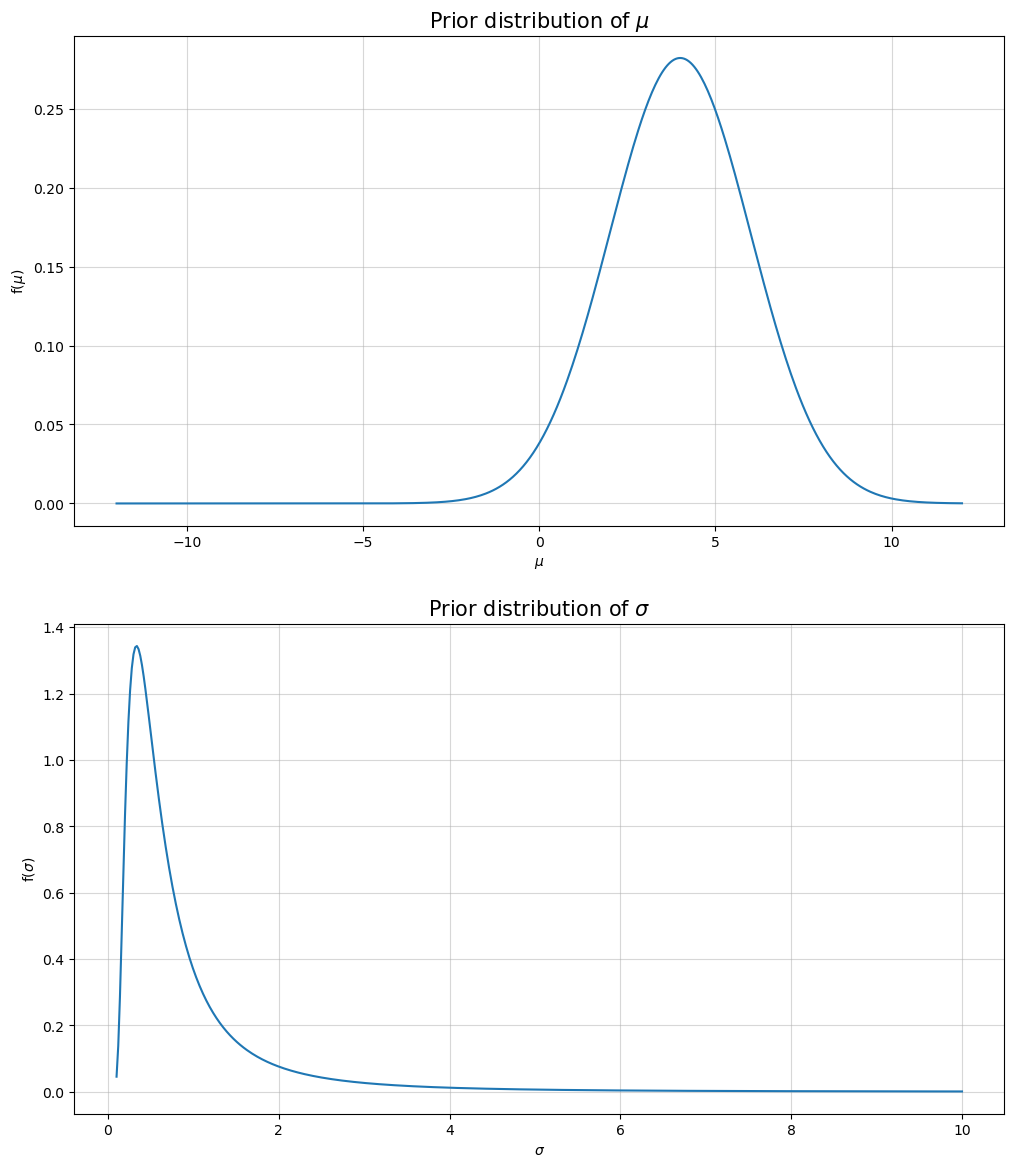

In [4]:
x_mu  = np.linspace(-12, 12, 500)
x_sigma  = np.linspace(0.1, 10, 500)

_, ax = plt.subplots(2, 1, figsize=(12, 14))
ax[0].plot(x_mu, np.exp(log_prior_mu(x_mu, m=4, s=2)))
ax[1].plot(x_sigma, np.exp(log_prior_sigma(x_sigma, alpha=2, beta=1)))

param_str = ['$\mu$', '$\sigma$']

for i in range(2):
    ax[i].set_title('Prior distribution of ' + param_str[i], fontsize=15)
    ax[i].set_xlabel(param_str[i], fontsize=10)
    ax[i].set_ylabel('f('+param_str[i]+')', fontsize=10)
    ax[i].grid(alpha=0.5)
    
plt.show()

In [5]:
def metropolis(p0, n_samples, burn_in, epsilon=0.005, x=data, log_func_post=log_posterior):
    '''
    INPUTS:
    p0            -> initial state of the Markov Chain, [mu_0, sigma_0]
    n_samples     -> number of required samples
    burn_in       -> discarded initial samples
    x             -> data samples
    log_func_post -> function returning a ln of the posterior distribution, not normalized with the evidence
    
    OUTPUT: 
    f_sampled     -> MCMC chain, shape (2, n_samples)
    r_accept      -> acceptance rate (computed only after the burn in)
    
    '''
    
    p_current = p0
    f_current = log_func_post(mu=p_current[0], sigma=p_current[1], x=x)  
        
    # initialize the chain object
    f_sampled = np.zeros((2, n_samples))
    f_burnin = np.zeros((2, burn_in))
    
    # acceptance/rejection rate
    n_accept = 0
    
    # MCMC algorithm
    i = 0
    while i<(burn_in + n_samples):
        # draw random sample
        p_prop = np.random.multivariate_normal(mean=p_current, cov=epsilon*np.eye(2))
        
        # Metropolis step
        if p_prop[1]>0:
            f_prop = log_posterior(mu=p_prop[0], sigma=p_prop[1], x=x)
            logMR =  f_prop - f_current
        else:
            logMR = -np.inf
        
        if logMR >= 0 or logMR >= np.log(np.random.uniform(0, 1)):
            p_current = p_prop
            f_current = f_prop 
            if i >= burn_in: 
                n_accept += 1
            
        if i >= burn_in:
            f_sampled[:, i-burn_in] = p_current
        else:
            f_burnin[:, i] = p_current
        
        i += 1
    
    r_accept = n_accept/n_samples
    
    return f_sampled, f_burnin, r_accept

In [6]:
p0 = np.array([4, 1])
burn_in = 2000
n_steps = 50000

epsilon_vec = [10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1), 0.5]

chains = []
chains_burnin = []
rates = []

for eps in epsilon_vec:
    print('Running eps=%.5f ...' %eps)
    tmp = metropolis(p0, n_samples=n_steps, burn_in=burn_in, epsilon=eps)
    chains.append(tmp[0])
    chains_burnin.append(tmp[1])
    rates.append(tmp[2])
    print('Done\n')

Running eps=0.00001 ...
Done

Running eps=0.00010 ...
Done

Running eps=0.00100 ...
Done

Running eps=0.01000 ...
Done

Running eps=0.10000 ...


C:\Users\Nicola\AppData\Local\Temp\ipykernel_22796\1001677515.py:11: RuntimeWarning: divide by zero encountered in log
  return np.log(inverse_gamma(sigma, alpha, beta))


Done

Running eps=0.50000 ...
Done



In [7]:
for i, eps in enumerate(epsilon_vec):
    print('The acceptance rate with eps=%.5f is %.3f%%' %(eps, rates[i]*100))

The acceptance rate with eps=0.00001 is 79.876%
The acceptance rate with eps=0.00010 is 45.966%
The acceptance rate with eps=0.00100 is 10.370%
The acceptance rate with eps=0.01000 is 1.208%
The acceptance rate with eps=0.10000 is 0.116%
The acceptance rate with eps=0.50000 is 0.026%


## Plot marginals

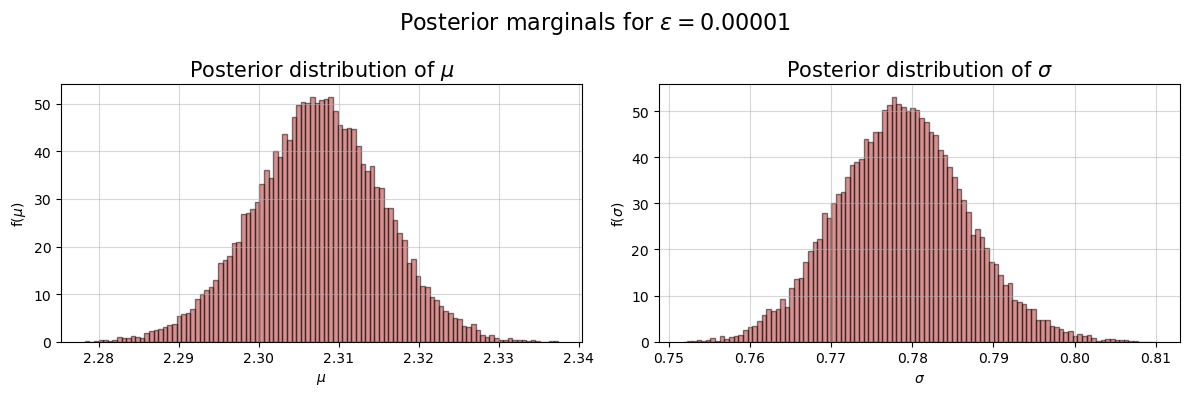

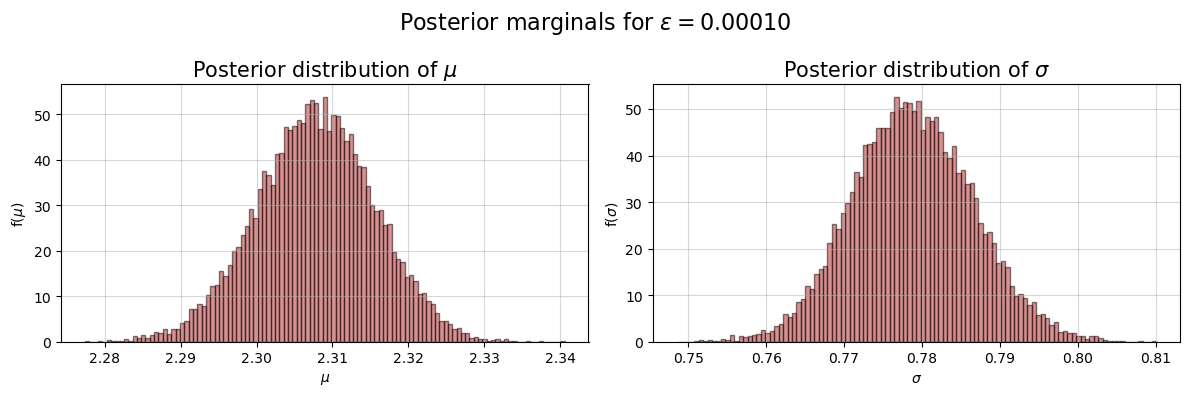

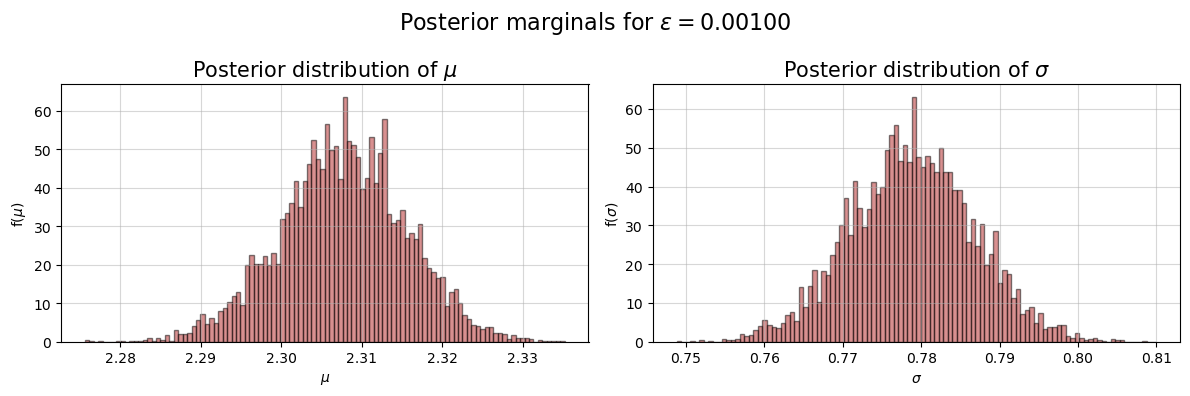

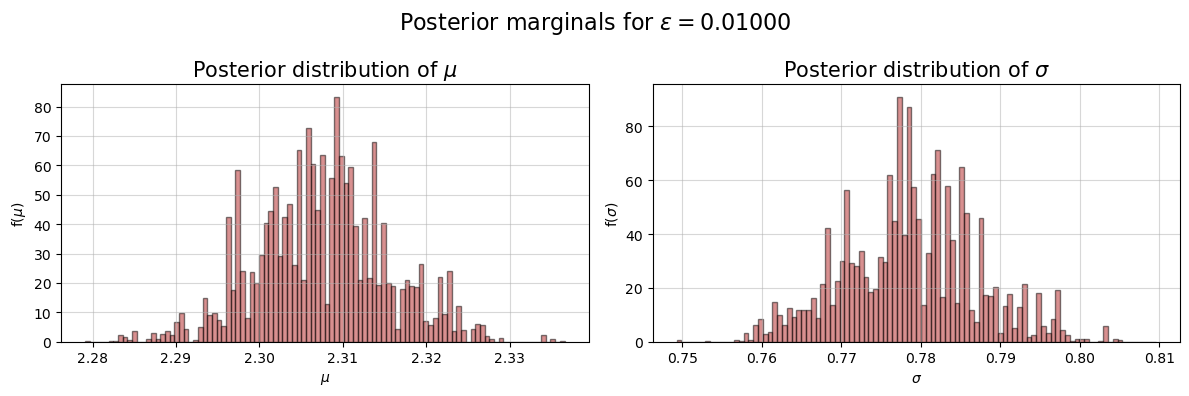

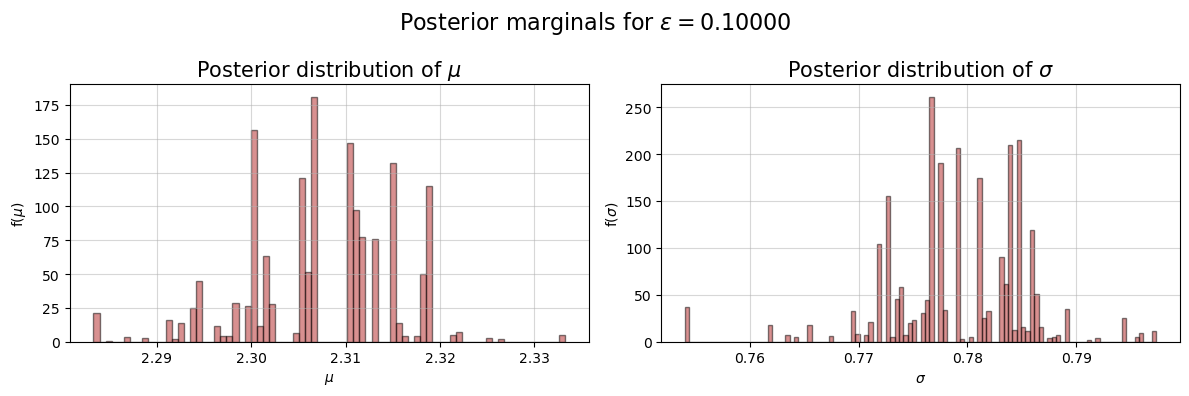

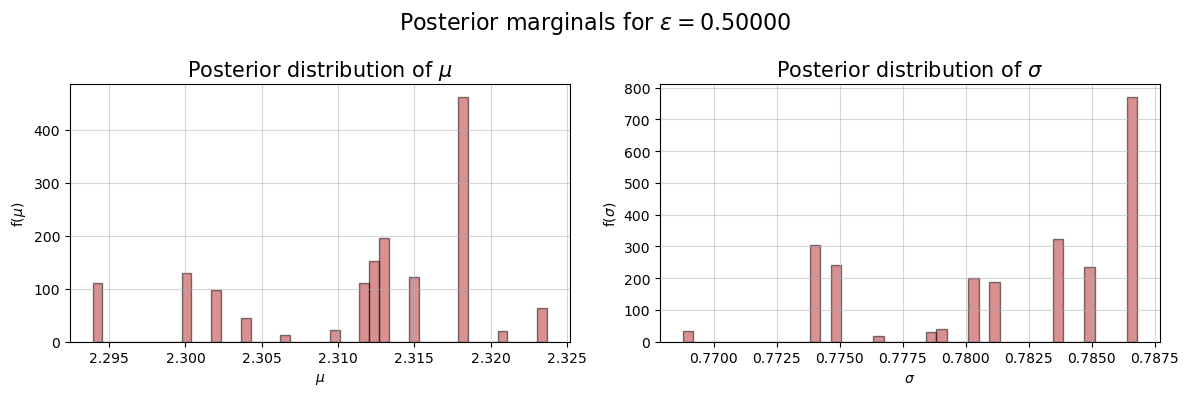

In [8]:
for eps, chain in zip(epsilon_vec, chains):    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    hist_0 = ax[0].hist(chain[0, :], bins='fd', edgecolor='black', alpha=0.5, density=True, color='firebrick')
    hist_1 = ax[1].hist(chain[1, :], bins='fd', edgecolor='black', alpha=0.5, density=True, color='firebrick')
    
    labels = ['$\mu$', '$\sigma$']
    for i, lab in enumerate(labels):
        ax[i].set_xlabel(lab, fontsize=10)
        ax[i].set_ylabel('f('+lab+')', fontsize=10)
        ax[i].grid(alpha=0.5)
        ax[i].set_title('Posterior distribution of '+lab, fontsize=15)
        
    fig.suptitle('Posterior marginals for $\epsilon=%.5f$' %eps, fontsize=16)

    plt.tight_layout()
    plt.show()


## Posterior mean and standard deviation

In [9]:
mu_vec = []
sg_vec = []

for eps, chain in zip(epsilon_vec, chains):
    mu_mean, mu_std = np.mean(chain[0, :]), np.std(chain[0, :])
    sg_mean, sg_std = np.mean(chain[1, :]), np.std(chain[1, :])
    print('--- Epsilon = %.5f ---' %eps)
    print('mu    = %.3f +- %.5f' %(mu_mean, mu_std))
    print('sigma = %.3f +- %.5f' %(sg_mean, sg_std))
    print('\n')
    
    mu_vec.append(mu_mean)
    sg_vec.append(sg_mean)
    

--- Epsilon = 0.00001 ---
mu    = 2.307 +- 0.00800
sigma = 0.779 +- 0.00790


--- Epsilon = 0.00010 ---
mu    = 2.308 +- 0.00783
sigma = 0.779 +- 0.00777


--- Epsilon = 0.00100 ---
mu    = 2.308 +- 0.00782
sigma = 0.779 +- 0.00792


--- Epsilon = 0.01000 ---
mu    = 2.307 +- 0.00789
sigma = 0.779 +- 0.00839


--- Epsilon = 0.10000 ---
mu    = 2.307 +- 0.00795
sigma = 0.779 +- 0.00646


--- Epsilon = 0.50000 ---
mu    = 2.312 +- 0.00796
sigma = 0.782 +- 0.00497




## Chain analysis

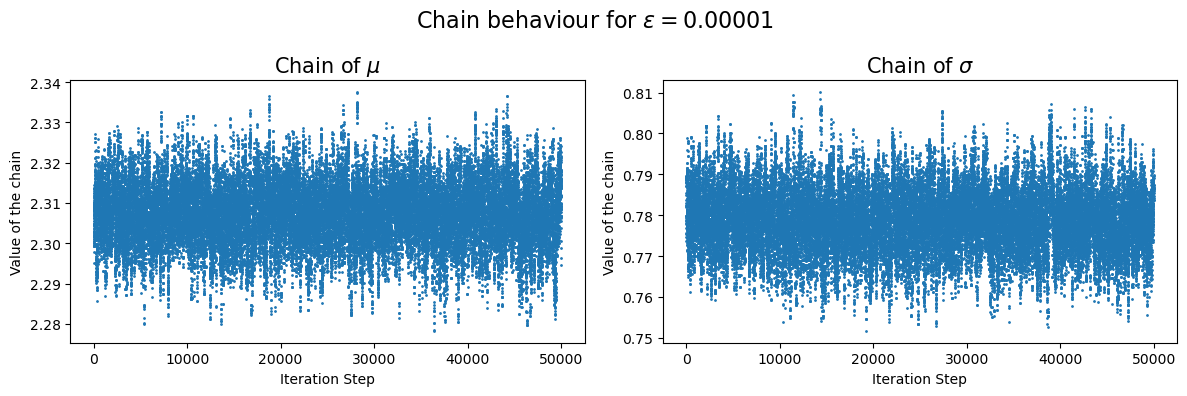

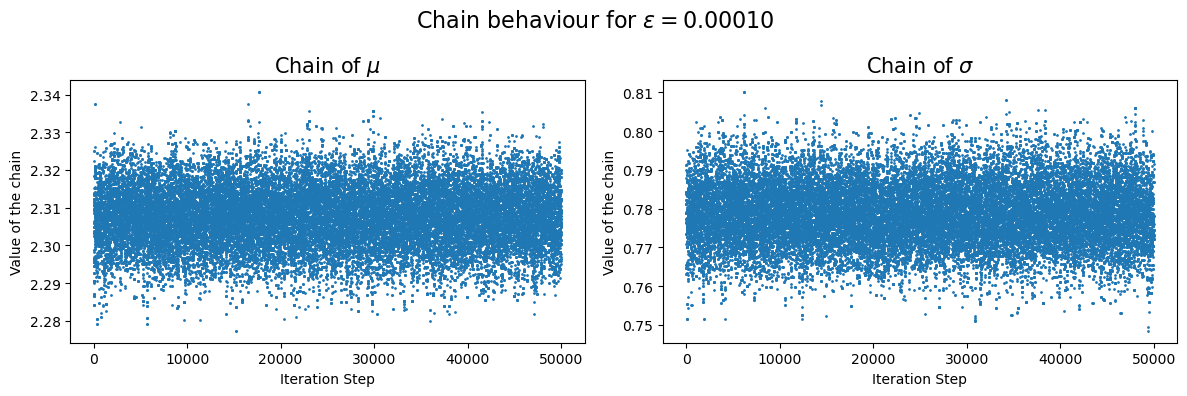

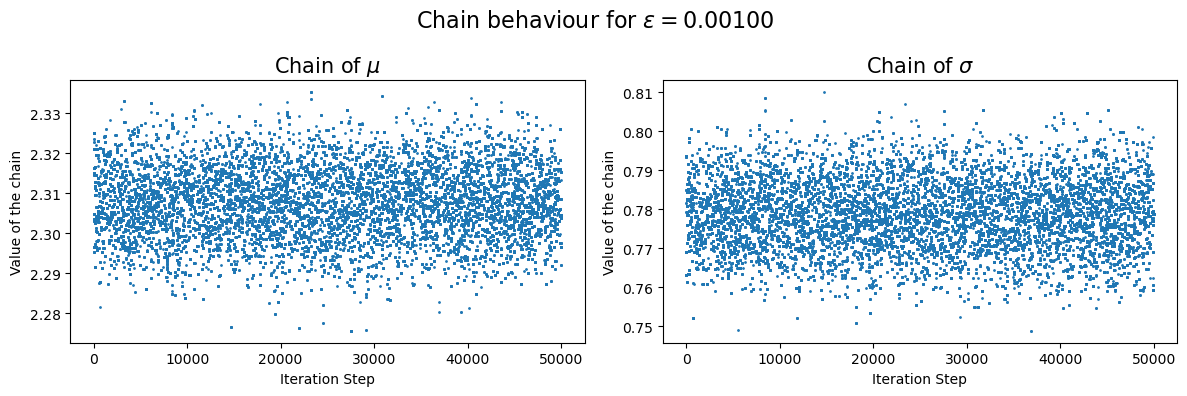

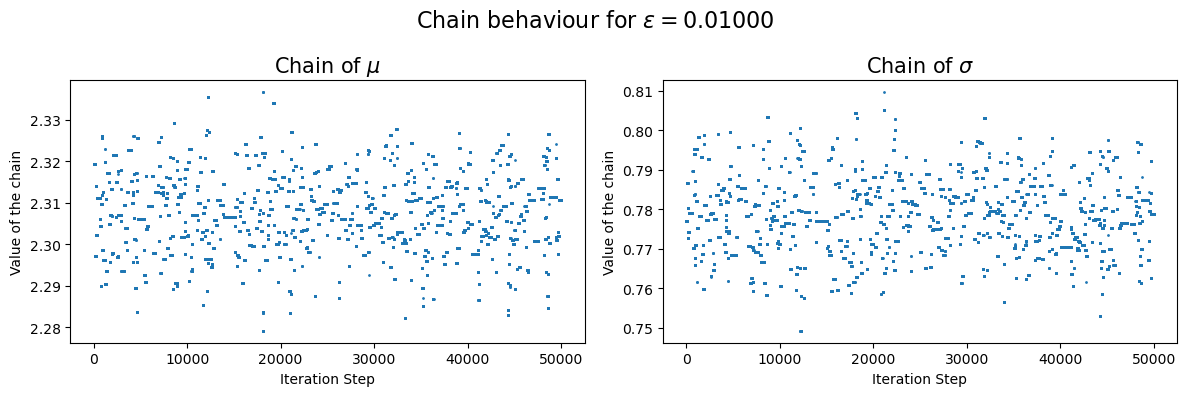

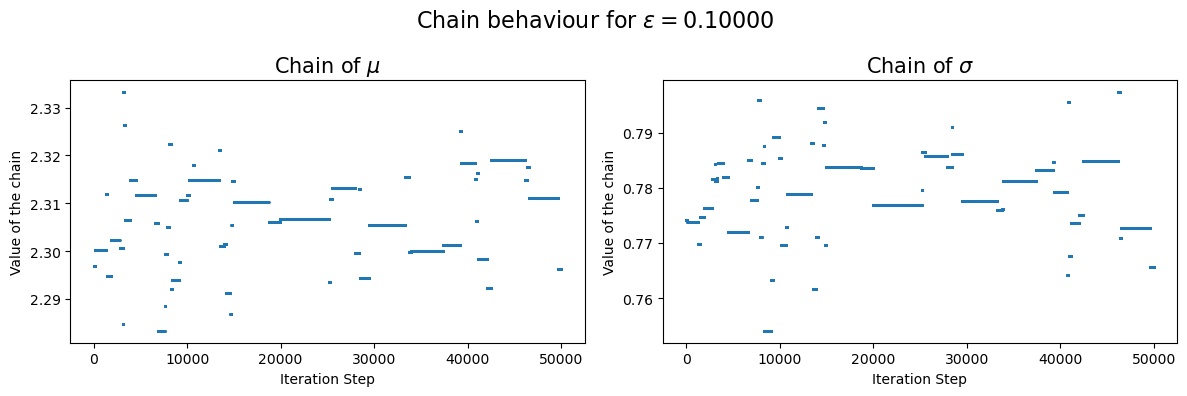

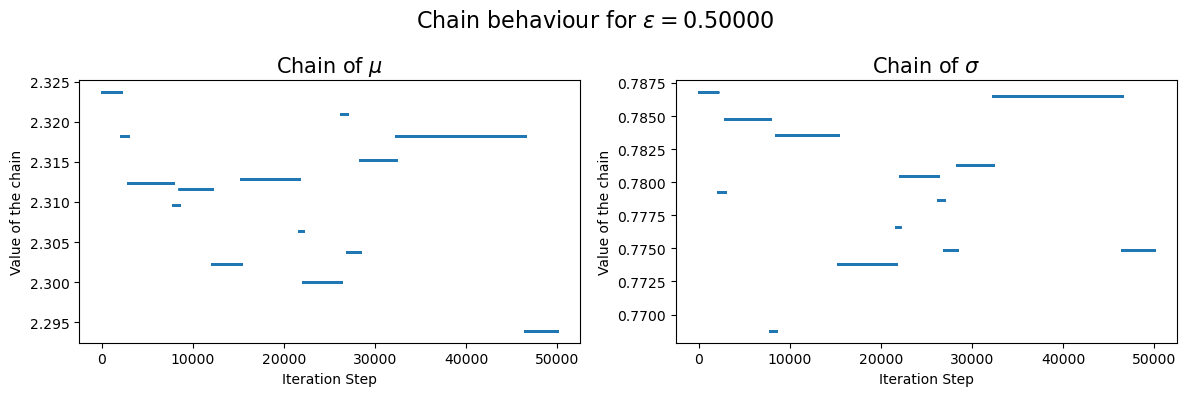

In [10]:
def plot_chain(chain_samples, var_names, plot_suptitle):

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(plot_suptitle, fontsize=16)
    
    for i in range(2):
        ax[i].scatter(range(0, chain_samples.shape[1]) , chain_samples[i, :], s=1)
        ax[i].set_xlabel('Iteration Step', fontsize=10)
        ax[i].set_ylabel('Value of the chain', fontsize=10)
        ax[i].set_title('Chain of '+ var_names[i], fontsize=15)
        
    plt.tight_layout()
    plt.show()
    
for eps, c in zip(epsilon_vec, chains):
    plot_chain(c, ['$\mu$', '$\sigma$'], 'Chain behaviour for $\epsilon=%.5f$' %eps)

## Analysis of burn in phase

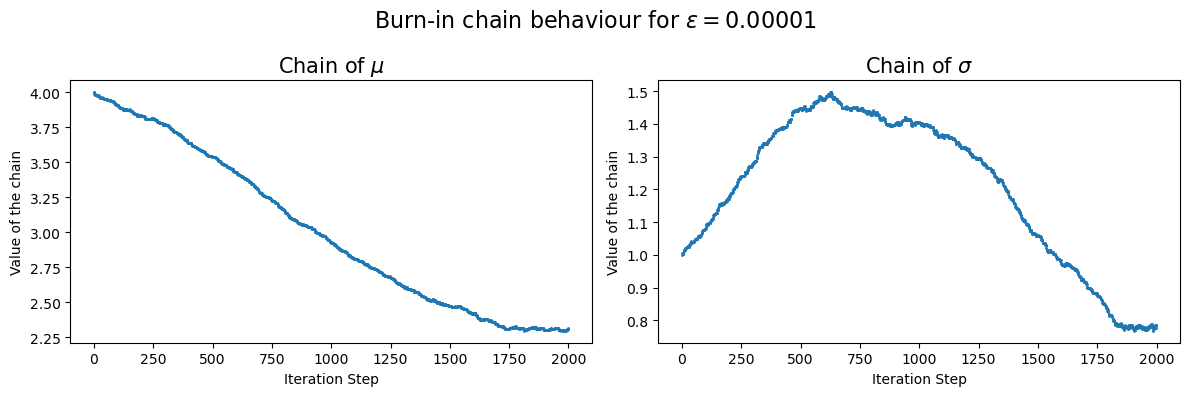

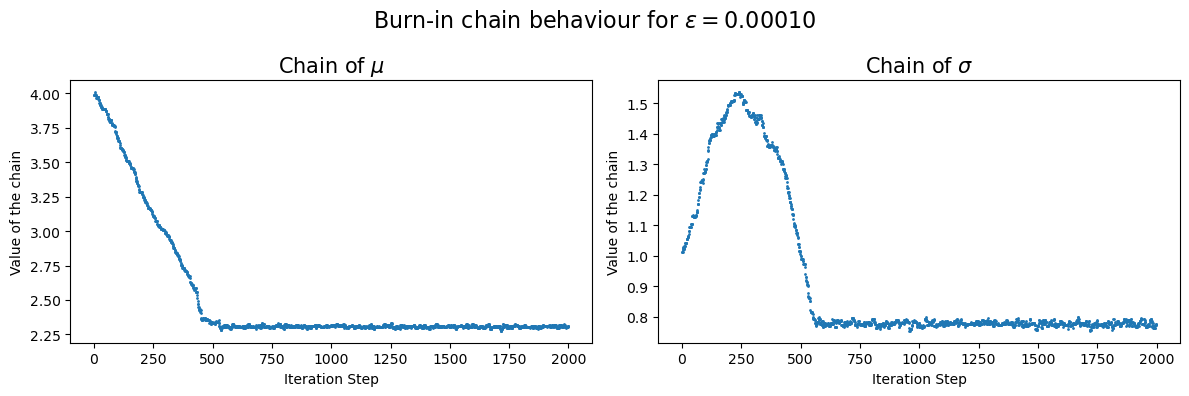

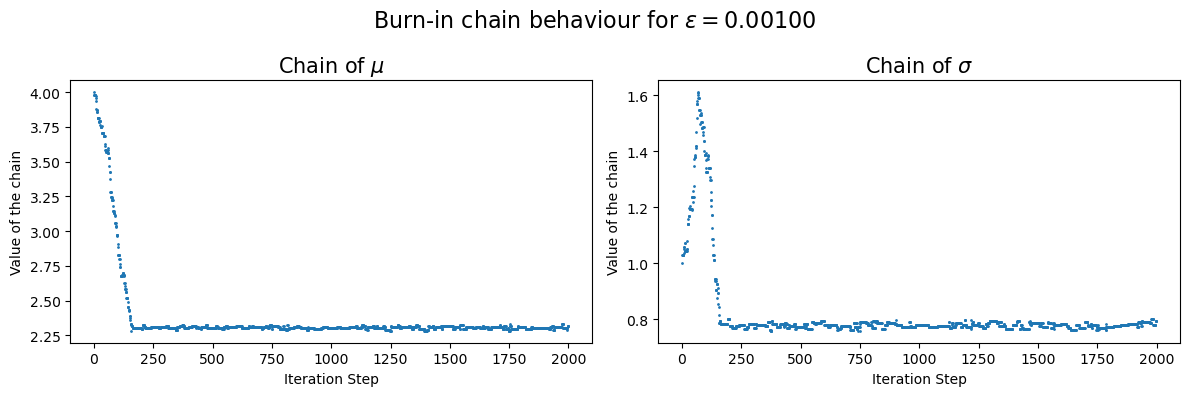

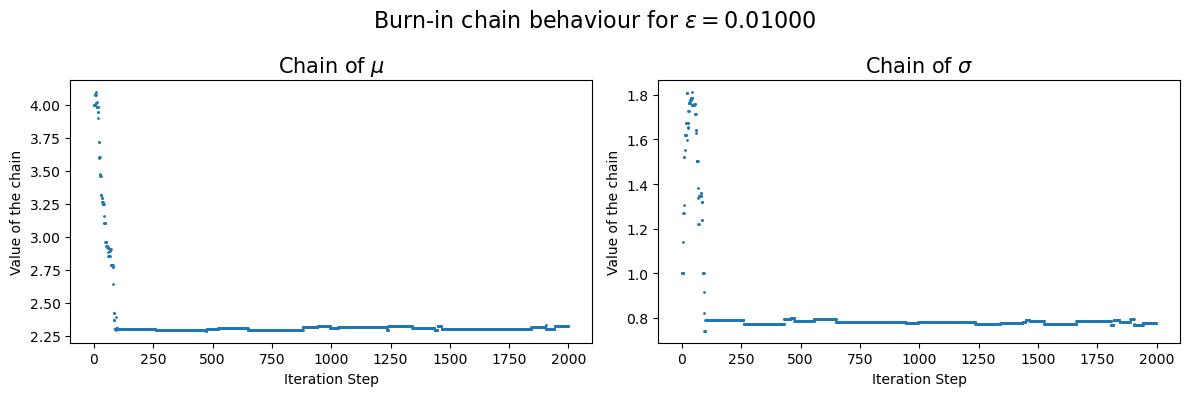

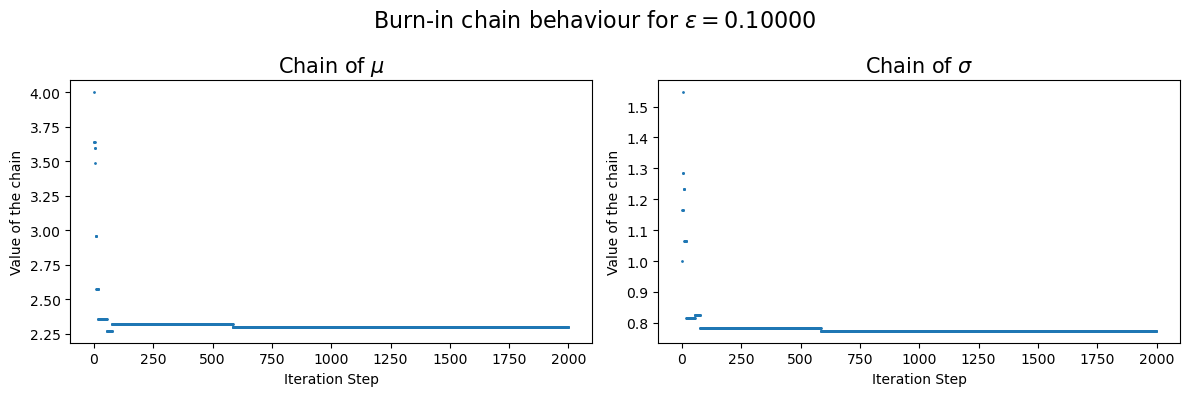

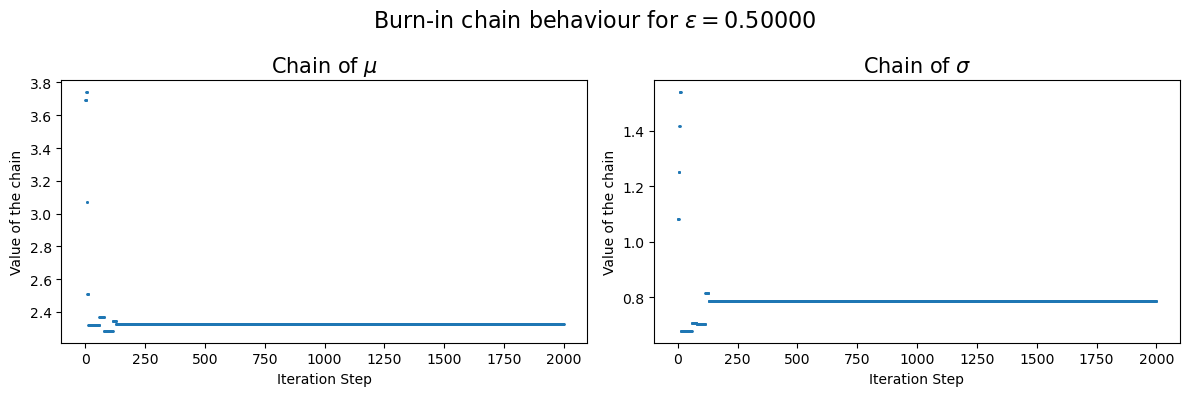

In [13]:
for eps, c in zip(epsilon_vec, chains_burnin):
    plot_chain(c, ['$\mu$', '$\sigma$'], 'Burn-in chain behaviour for $\epsilon=%.5f$' %eps)

## Looking for correlations

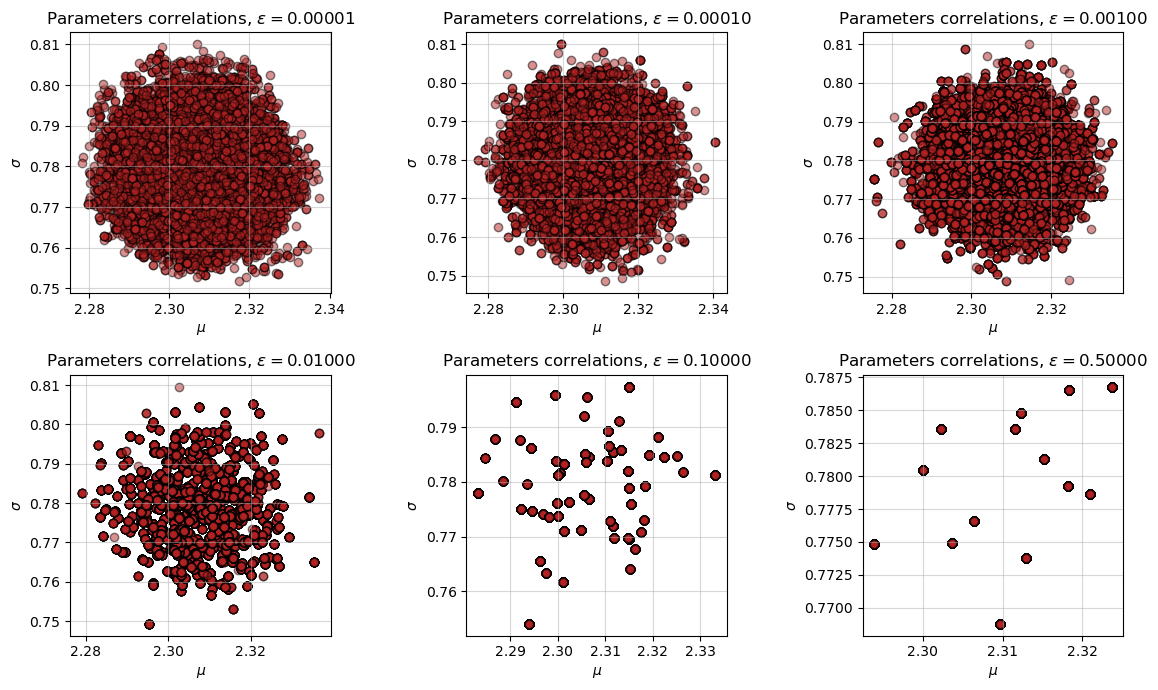

In [12]:
fig, ax = plt.subplots(nrows = 2, ncols=3, figsize=(12, 7))

for i, chain in enumerate(chains):
    ax[i//3, i%3].set_box_aspect(1)
    ax[i//3, i%3].scatter(chain[0, :], chain[1, :], edgecolors = 'black', facecolors='firebrick', alpha=0.5)
    ax[i//3, i%3].set_xlabel('$\mu$', fontsize=10)
    ax[i//3, i%3].set_ylabel('$\sigma$', fontsize=10)
    ax[i//3, i%3].grid(alpha=0.5)

    ax[i//3, i%3].set_title('Parameters correlations, $\epsilon=%.5f$' %epsilon_vec[i])

plt.tight_layout()
plt.show()
